In [26]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
import pandas as pd
from scipy import stats
from pydataset import data
import numpy as np
import env
import matplotlib.pyplot as plt
import os
import prepare
import wrangle
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import explore
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt

In [3]:
df = wrangle.get_zillow_sfr_data()

In [4]:
train, validate, test = wrangle.clean_prep_zillow(df)

In [5]:
train.head()

,bedroom,bathroom,sqrft,tax_value,year_built,taxamount,fips
1766466,3.0,2.0,1642.0,231120.0,1960.0,2898.13,6037.0
1073889,3.0,2.0,1858.0,178499.0,1955.0,2204.12,6059.0
1223806,5.0,5.0,4433.0,913447.0,2001.0,10717.51,6037.0
1694410,2.0,1.0,888.0,54621.0,1953.0,606.26,6037.0
1436362,2.0,2.0,1966.0,760368.0,1925.0,8290.04,6037.0


Fit a linear regression model (ordinary least squares) and compute yhat, predictions of taxvaluedollarcnt using only calculatedfinishedsqft.

In [13]:
baseline = round((train['tax_value'].mean()),2)

In [14]:
preds = train[['tax_value','sqrft']]

In [15]:
preds['baseline_preds'] = baseline
preds.head()

,tax_value,sqrft,baseline_preds
1766466,231120.0,1642.0,460889.16
1073889,178499.0,1858.0,460889.16
1223806,913447.0,4433.0,460889.16
1694410,54621.0,888.0,460889.16
1436362,760368.0,1966.0,460889.16


In [16]:
ols_model = LinearRegression()

ols_model.fit(train[['sqrft']], train[['tax_value']])

LinearRegression()

In [17]:
preds['yhat'] = ols_model.predict(train[['sqrft']])
preds.head()

,tax_value,sqrft,baseline_preds,yhat
1766466,231120.0,1642.0,460889.16,4.091226e+05
1073889,178499.0,1858.0,460889.16,4.593490e+05
1223806,913447.0,4433.0,460889.16,1.058113e+06
1694410,54621.0,888.0,460889.16,2.337953e+05
1436362,760368.0,1966.0,460889.16,4.844622e+05


Plot the residuals for the linear regression model that you made.

In [18]:
preds['baseline_res'] = preds['baseline_preds'] - preds['tax_value']
preds.head()

,tax_value,sqrft,baseline_preds,yhat,baseline_res
1766466,231120.0,1642.0,460889.16,4.091226e+05,229769.16
1073889,178499.0,1858.0,460889.16,4.593490e+05,282390.16
1223806,913447.0,4433.0,460889.16,1.058113e+06,-452557.84
1694410,54621.0,888.0,460889.16,2.337953e+05,406268.16
1436362,760368.0,1966.0,460889.16,4.844622e+05,-299478.84


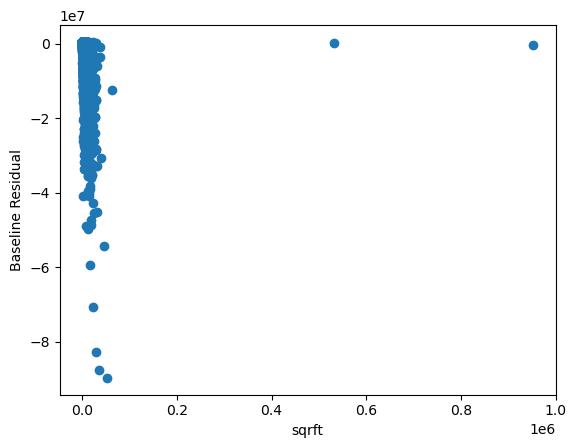

In [19]:
plt.scatter(preds['sqrft'], preds['baseline_res'])
plt.xlabel('sqrft')
plt.ylabel('Baseline Residual')
plt.show()

In [20]:
preds['yhat_res'] = preds['yhat'] - preds['tax_value']
preds.head()

,tax_value,sqrft,baseline_preds,yhat,baseline_res,yhat_res
1766466,231120.0,1642.0,460889.16,4.091226e+05,229769.16,178002.630956
1073889,178499.0,1858.0,460889.16,4.593490e+05,282390.16,280850.032318
1223806,913447.0,4433.0,460889.16,1.058113e+06,-452557.84,144665.844854
1694410,54621.0,888.0,460889.16,2.337953e+05,406268.16,179174.285460
1436362,760368.0,1966.0,460889.16,4.844622e+05,-299478.84,-275905.767000


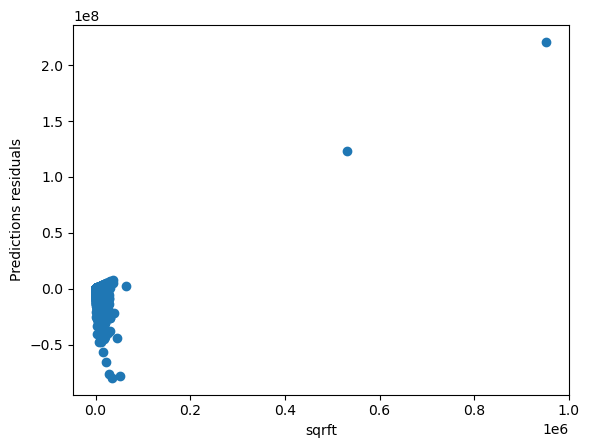

In [32]:
plt.scatter(preds['sqrft'], preds['yhat_res'])
plt.xlabel('sqrft')
plt.ylabel('Predictions residuals')
plt.show()

Calculate the sum of squared errors, explained sum of squares, total sum of squares, mean squared error, and root mean squared error for your model.

Calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model (i.e. a model that always predicts the average taxvaluedollarcnt amount).

Calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model (i.e. a model that always predicts the average taxvaluedollarcnt amount).

In [22]:
preds['baseline_res_squared'] = preds['baseline_res'] ** 2
preds['yhat_res_squared'] = preds['yhat_res'] ** 2
preds.head()

,tax_value,sqrft,baseline_preds,yhat,baseline_res,yhat_res,baseline_res_squared,yhat_res_squared
1766466,231120.0,1642.0,460889.16,4.091226e+05,229769.16,178002.630956,5.279387e+10,3.168494e+10
1073889,178499.0,1858.0,460889.16,4.593490e+05,282390.16,280850.032318,7.974420e+10,7.887674e+10
1223806,913447.0,4433.0,460889.16,1.058113e+06,-452557.84,144665.844854,2.048086e+11,2.092821e+10
1694410,54621.0,888.0,460889.16,2.337953e+05,406268.16,179174.285460,1.650538e+11,3.210342e+10
1436362,760368.0,1966.0,460889.16,4.844622e+05,-299478.84,-275905.767000,8.968758e+10,7.612399e+10


In [23]:
sse_baseline = preds['baseline_res_squared'].sum()
sse_yhat = preds['yhat_res_squared'].sum()
sse_baseline, sse_yhat

(6.913279888025121e+17, 5.509602060144793e+17)

In [24]:
mse_baseline = sse_baseline / len(preds)
mse_yhat = sse_yhat / len(preds)
mse_baseline, mse_yhat

(461450140840.73047, 367756938502.37976)

In [27]:
rmse_baseline = sqrt(mse_baseline)
rmse_yhat = sqrt(mse_yhat)
rmse_baseline, rmse_yhat

(679301.2151032342, 606429.6649260982)

In [29]:
preds['yhat_mean_res'] = preds['yhat'] - preds['baseline_preds']
preds.head()

,tax_value,sqrft,baseline_preds,yhat,baseline_res,yhat_res,baseline_res_squared,yhat_res_squared,yhat_mean_res
1766466,231120.0,1642.0,460889.16,4.091226e+05,229769.16,178002.630956,5.279387e+10,3.168494e+10,-51766.529044
1073889,178499.0,1858.0,460889.16,4.593490e+05,282390.16,280850.032318,7.974420e+10,7.887674e+10,-1540.127682
1223806,913447.0,4433.0,460889.16,1.058113e+06,-452557.84,144665.844854,2.048086e+11,2.092821e+10,597223.684854
1694410,54621.0,888.0,460889.16,2.337953e+05,406268.16,179174.285460,1.650538e+11,3.210342e+10,-227093.874540
1436362,760368.0,1966.0,460889.16,4.844622e+05,-299478.84,-275905.767000,8.968758e+10,7.612399e+10,23573.073000


In [30]:
preds['yhat_mean_res_squared'] = preds['yhat_mean_res'] ** 2
preds.head()

,tax_value,sqrft,baseline_preds,yhat,baseline_res,yhat_res,baseline_res_squared,yhat_res_squared,yhat_mean_res,yhat_mean_res_squared
1766466,231120.0,1642.0,460889.16,4.091226e+05,229769.16,178002.630956,5.279387e+10,3.168494e+10,-51766.529044,2.679774e+09
1073889,178499.0,1858.0,460889.16,4.593490e+05,282390.16,280850.032318,7.974420e+10,7.887674e+10,-1540.127682,2.371993e+06
1223806,913447.0,4433.0,460889.16,1.058113e+06,-452557.84,144665.844854,2.048086e+11,2.092821e+10,597223.684854,3.566761e+11
1694410,54621.0,888.0,460889.16,2.337953e+05,406268.16,179174.285460,1.650538e+11,3.210342e+10,-227093.874540,5.157163e+10
1436362,760368.0,1966.0,460889.16,4.844622e+05,-299478.84,-275905.767000,8.968758e+10,7.612399e+10,23573.073000,5.556898e+08


In [31]:
ess_baseline = 0
ess_yhat = preds['yhat_mean_res_squared'].sum()
ess_yhat

1.4036778278804811e+17

Write python code that compares the sum of squared errors for your model against the sum of squared errors for the baseline model and outputs whether or not your model performs better than the baseline model.

In [34]:
if sse_baseline < sse_yhat:
    print('your model is shite')
else:
    print('your model has passed')

your model has passed


What is the amount of variance explained in your model?

In [35]:
evs = explained_variance_score(preds.tax_value, preds.yhat)
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.203


Is your model better than the baseline model?

-Yes?

Create a file named evaluate.py that contains the following functions.

plot_residuals(y, yhat): creates a residual plot


regression_errors(y, yhat): returns the following values:
sum of squared errors (SSE)

explained sum of squares (ESS)

total sum of squares (TSS)

mean squared error (MSE)

root mean squared error (RMSE)

baseline_mean_errors(y): computes the SSE, MSE, and RMSE for the baseline model

better_than_baseline(y, yhat): returns true if your model performs better than the baseline, otherwise false
